In [79]:
import pandas as pd
import matplotlib.pyplot as plt

# Competitiveness against fossil fuels

In [80]:
# state-level natural gas prices
state_ng = pd.read_excel('./input_data/ng_prices_state_annual_us.xlsx', sheet_name='clean_data_2022', header=0 ).transpose()
state_ng.reset_index(inplace=True)
state_ng.rename(columns={0:'NG price ($/MMBtu)', 'index':'state'}, inplace=True)
state_ng['state'] = state_ng.apply(lambda x:x['state'].split(' Natural')[0], axis=1)
state_ng.set_index('state', inplace=True)

In [81]:
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}
abbrev_states = pd.DataFrame(us_state_to_abbrev.items(), columns=['state', 'abbrev'])

abbrev_states.set_index('state', inplace=True)
state_ng = state_ng.merge(abbrev_states, on='state')
state_ng.reset_index(inplace=True)
state_ng.head(2)

,state,NG price ($/MMBtu),abbrev
0,Alabama,7.87,AL
1,Alaska,6.72,AK


In [82]:
ammonia = pd.read_csv('./results/ammonia_anr_lr_0_h2_lr_0_wacc_0.077_clean.csv')
heat = pd.read_csv('./results/process_heat_anr_lr_0_h2_lr_0_wacc_0.077_clean.csv')
refining = pd.read_csv('./results/refining_anr_lr_0_h2_lr_0_wacc_0.077_clean.csv')
ammonia = ammonia[['state', 'Breakeven NG price ($/MMBtu)', 'ANR']]
ammonia['Industry'] = 'Ammonia'
heat = heat[['state', 'Breakeven NG price ($/MMBtu)', 'ANR']]
heat['Industry'] = 'Process heat'



In [83]:
refining = refining[['state', 'Breakeven price ($/MMBtu)', 'ANR']]
abbrev_states.reset_index(inplace=True)
abbrev_states['state'] = abbrev_states.apply(lambda x:x['state'].upper(), axis=1)
refining = refining.merge(abbrev_states,left_on='state', right_on='state')
refining['Industry'] = 'Refining'
refining.drop(columns=['state'], inplace=True)
refining.rename(columns={'Breakeven price ($/MMBtu)':'Breakeven NG price ($/MMBtu)', \
                         'abbrev':'state'}, inplace=True)


In [84]:
total = pd.concat([ammonia, heat, refining], ignore_index=True)
total.head(3)

,state,Breakeven NG price ($/MMBtu),ANR,Industry
0,LA,21.6,iMSR,Ammonia
1,OK,21.6,iMSR,Ammonia
2,AK,22.1,iMSR,Ammonia


In [109]:
total_with_ng = total.merge(state_ng, left_on='state', right_on='abbrev')
total_with_ng.rename(columns={'NG price ($/MMBtu)':'State-level industrial NG price ($/MMBtu)'}, inplace=True)
print(total_with_ng.sort_values(by='State-level industrial NG price ($/MMBtu)').tail(20))

    state_x  Breakeven NG price ($/MMBtu)       ANR      Industry  \
327      NJ                          25.7     Micro      Refining   
325      NJ                          74.4     Micro  Process heat   
341      DE                          48.9     Micro  Process heat   
340      DE                          21.5     Micro  Process heat   
342      DE                          12.2  PBR-HTGR      Refining   
323      MD                          20.0  PBR-HTGR  Process heat   
243      CA                          16.7     Micro      Refining   
244      CA                          43.7     Micro      Refining   
233      CA                          41.1     Micro       Ammonia   
234      CA                          29.2     Micro  Process heat   
235      CA                          31.0     Micro  Process heat   
236      CA                          34.9     Micro  Process heat   
237      CA                           9.5  PBR-HTGR      Refining   
238      CA                       

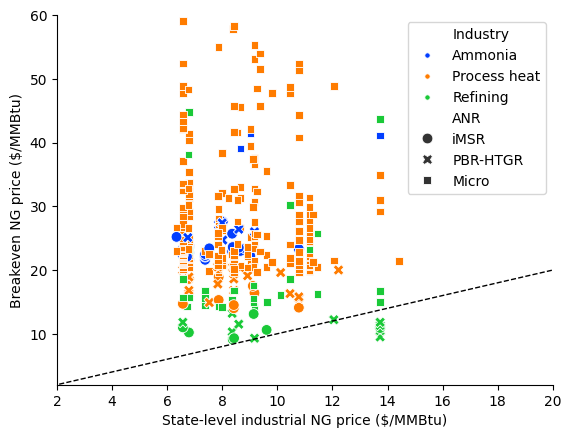

In [111]:
# plot
import seaborn as sns
import numpy as np
ax = sns.scatterplot(data=total_with_ng, x='State-level industrial NG price ($/MMBtu)',\
                     y='Breakeven NG price ($/MMBtu)', hue='Industry', palette='bright', style='ANR', marker='.', s=60)
ax.set_ylim(2,60)
ax.set_xlim(2,20)
med_x = np.arange(0,50,0.05)
ax.plot(med_x, med_x, color='k', linestyle='--', linewidth=1, label='No CO2 tax')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig('./results/be_ng_state.png')

# Economic impact of incentives

In [87]:
carbon_prices = [230, 270, 310] #$/tCO2 for 2030, 2040, 2050 from EPA social cost of carbon
h2_ptc = 3 #$/kgH2 clean
elec_ptc = 25 #$/MWhe
avg_elec_cons_h2 = 0.022 #MWhe/kgh2, calculated from avg thermal efficiency (micro, PBR-HTGR, iMSR) and coupling efficiency with HTSE

# NH3
nh3_carbon_intensity = 2.30 # tcO2/tNH3
nh3_nrj_intensity = 30.82 #MMBtu/tNH3
nh3_h2_intensity = 507.71 # kgh2/tNH3
nh3_carbon_prices = [c*nh3_carbon_intensity/nh3_nrj_intensity for c in carbon_prices]
nh3_h2_ptc = h2_ptc*nh3_h2_intensity/nh3_nrj_intensity
nh3_elec_ptc = elec_ptc*avg_elec_cons_h2*nh3_h2_intensity/nh3_nrj_intensity

# Refining
smr_carbon_intensity = 11.888 #kgCO2/kgh2
smr_nrj_intensity = 0.1578 # MMBtu/kgh2
refining_carbon_prices = [c*smr_carbon_intensity/(1e3*smr_nrj_intensity) for c in carbon_prices]
refining_h2_ptc = h2_ptc/smr_nrj_intensity
refining_elec_ptc = elec_ptc*avg_elec_cons_h2/smr_nrj_intensity

# Process heat
heat_avg_carbon_intensity = 0.002028 #tCO2/MMBtu
h2_hhv = 141.88 # MJ/kgh2
mmbtu_to_mj = 1055.06 #mj/MmBtu
heat_carbon_prices = [c*heat_avg_carbon_intensity for c in carbon_prices]
heat_h2_ptc = h2_ptc*mmbtu_to_mj/h2_hhv
heat_elec_ptc = elec_ptc*avg_elec_cons_h2*mmbtu_to_mj/h2_hhv



## Ammonia

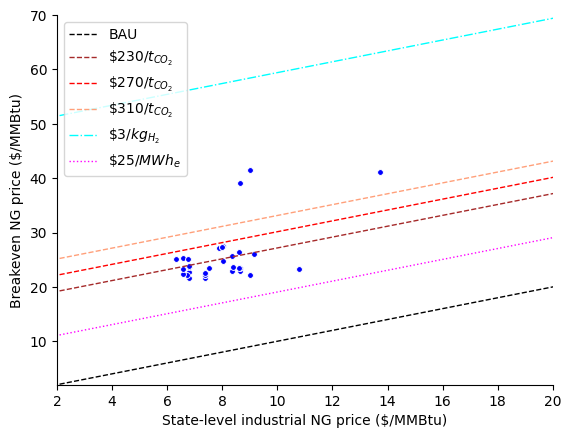

In [88]:
# Plot
ax = sns.scatterplot(data=total_with_ng[total_with_ng['Industry']=='Ammonia'], x='State-level industrial NG price ($/MMBtu)',\
                     y='Breakeven NG price ($/MMBtu)',color='b', marker='.', s=70)
ax.set_ylim(2,70)
ax.set_xlim(2,20)

# BAU
med_x = np.arange(0,50,0.05)
ax.plot(med_x, med_x, 'k--', linewidth=1, label='BAU')
#  EPA social cost of carbon pricing
c2030 = [x+nh3_carbon_prices[0] for x in med_x]
ax.plot(med_x, c2030, color='brown', linestyle='--', linewidth=1, label=r'\$230/$t_{CO_2}$')
c2040= [x+nh3_carbon_prices[1] for x in med_x]
ax.plot(med_x, c2040, color='r', linestyle='--', linewidth=1, label=r'\$270/$t_{CO_2}$')
c2050= [x+nh3_carbon_prices[2] for x in med_x]
ax.plot(med_x, c2050, color='lightsalmon', linestyle='--', linewidth=1, label=r'\$310/$t_{CO_2}$')
h2 = [x+nh3_h2_ptc for x in med_x]
ax.plot(med_x, h2, color='cyan', linestyle='-.', linewidth =1, label=r'\$3/$kg_{H_2}$')
elec = [x+nh3_elec_ptc for x in med_x]
ax.plot(med_x, elec, color='magenta', linestyle='dotted', linewidth =1, label=r'\$25/$MWh_e$')

ax.spines[['right', 'top']].set_visible(False)
ax.legend(loc=0)
plt.savefig('./results/ammonia_be_state_with_carbon_prices.png')

## Process heat

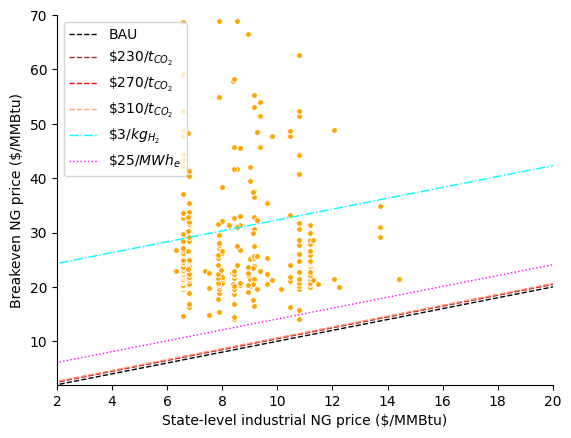

In [89]:
# Plot
ax = sns.scatterplot(data=total_with_ng[total_with_ng['Industry']=='Process heat'], x='State-level industrial NG price ($/MMBtu)',\
                     y='Breakeven NG price ($/MMBtu)',color='orange', marker='.', s=70)
ax.set_ylim(2,70)
ax.set_xlim(2,20)

# BAU
med_x = np.arange(0,50,0.05)
ax.plot(med_x, med_x, 'k--', linewidth=1, label='BAU')
#  EPA social cost of carbon pricing
c2030 = [x+heat_carbon_prices[0] for x in med_x]
ax.plot(med_x, c2030, color='brown', linestyle='--', linewidth=1, label=r'\$230/$t_{CO_2}$')
c2040= [x+heat_carbon_prices[1] for x in med_x]
ax.plot(med_x, c2040, color='r', linestyle='--', linewidth=1, label=r'\$270/$t_{CO_2}$')
c2050= [x+heat_carbon_prices[2] for x in med_x]
ax.plot(med_x, c2050, color='lightsalmon', linestyle='--', linewidth=1, label=r'\$310/$t_{CO_2}$')
h2 = [x+heat_h2_ptc for x in med_x]
ax.plot(med_x, h2, color='cyan', linestyle='-.', linewidth =1, label=r'\$3/$kg_{H_2}$')
elec = [x+heat_elec_ptc for x in med_x]
ax.plot(med_x, elec, color='magenta', linestyle='dotted',linewidth =1, label=r'\$25/$MWh_e$')



ax.spines[['right', 'top']].set_visible(False)
ax.legend(loc=0)
plt.savefig('./results/process_heat_be_state_with_carbon_prices.png')

## Refining

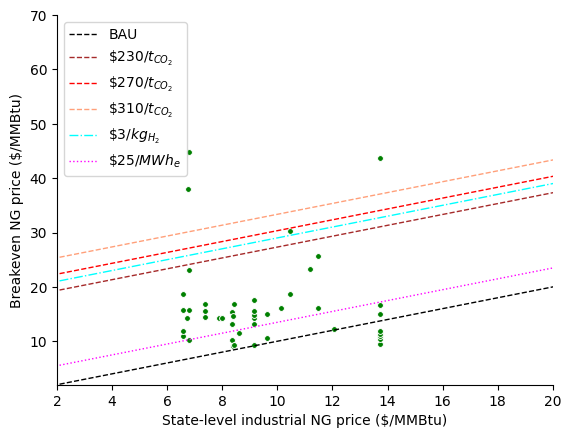

In [90]:
# Plot
ax = sns.scatterplot(data=total_with_ng[total_with_ng['Industry']=='Refining'], x='State-level industrial NG price ($/MMBtu)',\
                     y='Breakeven NG price ($/MMBtu)',color='g', marker='.', s=70)
ax.set_ylim(2,70)
ax.set_xlim(2,20)

# BAU
med_x = np.arange(0,50,0.05)
ax.plot(med_x, med_x, 'k--', linewidth=1, label='BAU')
#  EPA social cost of carbon pricing
c2030 = [x+refining_carbon_prices[0] for x in med_x]
ax.plot(med_x, c2030, color='brown', linestyle='--', linewidth=1, label=r'\$230/$t_{CO_2}$')
c2040= [x+refining_carbon_prices[1] for x in med_x]
ax.plot(med_x, c2040, color='r', linestyle='--', linewidth=1, label=r'\$270/$t_{CO_2}$')
c2050= [x+refining_carbon_prices[2] for x in med_x]
ax.plot(med_x, c2050, color='lightsalmon', linestyle='--', linewidth=1, label=r'\$310/$t_{CO_2}$')
h2 = [x+refining_h2_ptc for x in med_x]
ax.plot(med_x, h2, color='cyan', linestyle='-.', linewidth =1, label=r'\$3/$kg_{H_2}$')
elec = [x+refining_elec_ptc for x in med_x]
ax.plot(med_x, elec, color='magenta', linestyle='dotted',linewidth =1, label=r'\$25/$MWh_e$')

ax.spines[['right', 'top']].set_visible(False)
ax.legend(loc=0)
plt.savefig('./results/refining_be_state_with_carbon_prices.png')

## Steel

In [91]:
# Steel
coal_to_steel_ratio_bau = 0.474 # tcoal/tsteel
co2_to_steel_ratio_bau = 1.990 #tco2/tsteel
h2_to_dri_ratio = 67.095 #kgh2/tdri
steel_to_dri_ratio = 0.9311 # tsteel/tdri
aux_elec_dri = 0.1025 # MWhe/tdri
eaf_elec = 0.461 # MWhe/tsteel
steel_carbon_prices = [c*co2_to_steel_ratio_bau/coal_to_steel_ratio_bau for c in carbon_prices]
steel_h2_ptc = h2_ptc*h2_to_dri_ratio/(steel_to_dri_ratio*coal_to_steel_ratio_bau) 
steel_elec_ptc = elec_ptc* ( (avg_elec_cons_h2*h2_to_dri_ratio/steel_to_dri_ratio) + eaf_elec + (aux_elec_dri/steel_to_dri_ratio))/coal_to_steel_ratio_bau

In [92]:
steel = pd.read_csv('./results/steel_anr_lr_0_h2_lr_0_wacc_0.077_clean.csv')
division_coal = pd.read_excel('./input_data/coal_prices_2023_division_us.xlsx', sheet_name='coal_prices')
state_to_division_map = pd.read_excel('./input_data/coal_prices_2023_division_us.xlsx', sheet_name='state_to_division_map')
state_coal = state_to_division_map.merge(division_coal, on='division')
steel_with_state_prices = steel.merge(state_coal, on='state')
steel_with_state_prices['Industry'] = 'Steel'

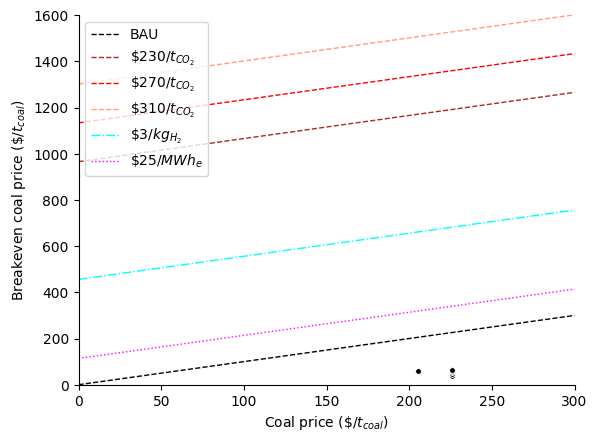

In [93]:
# Plot
ax = sns.scatterplot(data=steel_with_state_prices, x='price 2023 ($/tcoal)',\
                     y='Breakeven coal price ($/ton)',color='k', marker='.', s=70)
ax.set_ylim(0,1600)
ax.set_xlim(0,300)
ax.set_xlabel(r'Coal price ($\$/t_{coal}$)')
ax.set_ylabel(r'Breakeven coal price ($\$/t_{coal}$)')

# BAU
med_x = np.arange(0,500,0.05)
ax.plot(med_x, med_x, 'k--', linewidth=1, label='BAU')
#  EPA social cost of carbon pricing
c2030 = [x+steel_carbon_prices[0] for x in med_x]
ax.plot(med_x, c2030, color='brown', linestyle='--', linewidth=1, label=r'\$230/$t_{CO_2}$')
c2040= [x+steel_carbon_prices[1] for x in med_x]
ax.plot(med_x, c2040, color='r', linestyle='--', linewidth=1, label=r'\$270/$t_{CO_2}$')
c2050= [x+steel_carbon_prices[2] for x in med_x]
ax.plot(med_x, c2050, color='lightsalmon', linestyle='--', linewidth=1, label=r'\$310/$t_{CO_2}$')
h2 = [x+steel_h2_ptc for x in med_x]
ax.plot(med_x, h2, color='cyan', linestyle='-.', linewidth =1, label=r'\$3/$kg_{H_2}$')
elec = [x+steel_elec_ptc for x in med_x]
ax.plot(med_x, elec, color='magenta', linestyle='dotted',linewidth =1, label=r'\$25/$MWh_e$')

ax.spines[['right', 'top']].set_visible(False)
ax.legend(loc='upper left')
plt.savefig('./results/steel_be_state_with_carbon_prices.png')

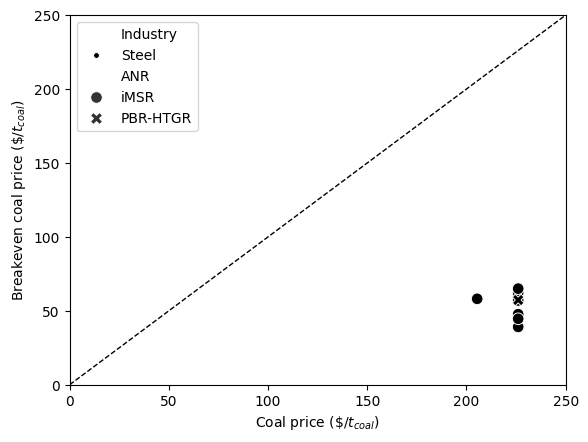

In [94]:
# Plot
ax = sns.scatterplot(data=steel_with_state_prices, x='price 2023 ($/tcoal)',\
                     y='Breakeven coal price ($/ton)',palette=['k'], marker='.', style='ANR',s=70, hue='Industry')
ax.set_ylim(0,250)
ax.set_xlim(0,250)
ax.set_xlabel(r'Coal price ($\$/t_{coal}$)')
ax.set_ylabel(r'Breakeven coal price ($\$/t_{coal}$)')

# BAU
med_x = np.arange(0,500,0.05)
ax.plot(med_x, med_x, 'k--', linewidth=1, label='BAU')
plt.savefig('./results/be_coal_state.png')

# Comparison against revenues from electricity sales

In [95]:
electricity_prices_hub = pd.read_excel('./input_data/electricity_prices_hubs_2023.xlsx', sheet_name='data')
state_hub_map = pd.read_excel('./input_data/electricity_prices_hubs_2023.xlsx', sheet_name='state_to_hub')
electricity_prices = state_hub_map.merge(electricity_prices_hub, on='hub')
#electricity_prices = electricity_prices[['state', 'average price ($/MWhe)']]
electricity_prices.head(3)

,state,hub,average price ($/MWhe)
0,WA,Northwest,78
1,OR,Northwest,78
2,MT,Northwest,78


In [96]:
# Results re-load
ammonia = pd.read_csv('./results/ammonia_anr_lr_0_h2_lr_0_wacc_0.077.csv')
heat = pd.read_csv('./results/process_heat_anr_lr_0_h2_lr_0_wacc_0.077.csv')
refining = pd.read_csv('./results/refining_anr_lr_0_h2_lr_0_wacc_0.077.csv')
steel = pd.read_csv('./results/steel_anr_lr_0_h2_lr_0_wacc_0.077.csv')


In [97]:
ammonia = ammonia.merge(electricity_prices, on='state')
ammonia['Elec sales (bn$/year)'] = ammonia['Depl. ANR Cap. (MWe)']*ammonia['average price ($/MWhe)']*24*365/1e9 #$/year
ammonia['Avoided fossil fuel cost (bn$/year)'] = nh3_nrj_intensity*ammonia['Ammonia capacity (tNH3/year)']*ammonia['Breakeven NG price ($/MMBtu)']/1e9
ammonia.head(3)

,plant_id,state,Ammonia capacity (tNH3/year),H2 Dem (kg/day),Aux Elec Dem (MWe),Net Rev. ($/year),PEM,Alkaline,HTSE,Ann. CO2 emissions (kgCO2eq/year),...,Conversion costs ($/year),ANR CRF,Depl. ANR Cap. (MWe),ANR type,# ANR modules,Breakeven NG price ($/MMBtu),hub,average price ($/MWhe),Elec sales (bn$/year),Avoided fossil fuel cost (bn$/year)
0,CF_Do,LA,3935000.0,5.441214e+06,53.454909,-2.624499e+09,0,0,5442.0,5.103946e+08,...,4.497249e+06,0.086325,4935.0,iMSR,35,21.581213,MISO,34,1.469840,2.617298
1,Nu_Ge,LA,535000.0,7.397839e+05,7.267694,-3.754586e+08,0,0,740.0,6.940317e+07,...,4.497249e+06,0.086325,705.0,iMSR,5,22.711285,MISO,34,0.209977,0.374480
2,Mo_Fa,LA,510000.0,7.052145e+05,6.928082,-3.724385e+08,0,0,706.0,6.621437e+07,...,4.497249e+06,0.086325,705.0,iMSR,5,23.635353,MISO,34,0.209977,0.371505


In [98]:
heat = heat.merge(electricity_prices, on='state')
heat['Elec sales (bn$/year)'] = heat['Depl. ANR Cap. (MWe)']*heat['average price ($/MWhe)']*24*365/1e9 #$/year
heat['Avoided fossil fuel cost (bn$/year)'] = heat['Heat Dem. (MJ/year)']*heat['Breakeven NG price ($/MMBtu)']/(mmbtu_to_mj*1e9)
heat.head(3)

,FACILITY_ID,state,H2 Dem. (kg/day),Heat Dem. (MJ/year),Cost ($/year),Ann. CO2 emissions (kgCO2eq/year),ANR CAPEX ($/year),H2 CAPEX ($/year),ANR O&M ($/year),H2 O&M ($/year),...,HTSE,PEM,Alkaline,ANR type,# ANR modules,Breakeven NG price ($/MMBtu),hub,average price ($/MWhe),Elec sales (bn$/year),Avoided fossil fuel cost (bn$/year)
0,1000588,IN,153100.342414,7.928485e+09,-1.055331e+08,1.444336e+07,3.485662e+07,6.192304e+06,26189340.0,7.486971e+06,...,154.0,0.0,0.0,iMSR,1,14.043456,MISO,34,0.041995,0.105533
1,1000418,IN,433411.991729,2.244476e+10,-3.089026e+08,4.070402e+07,1.045699e+08,1.745104e+07,78568020.0,2.109964e+07,...,434.0,0.0,0.0,iMSR,3,14.520518,MISO,34,0.125986,0.308901
2,1003962,IN,217798.459719,1.127895e+10,-1.800861e+08,1.970790e+07,6.626269e+07,8.449368e+06,51331200.0,1.021594e+07,...,218.0,0.0,0.0,PBR-HTGR,3,16.845609,MISO,34,0.071482,0.180085


In [99]:
refining = refining.merge(abbrev_states, on='state')
refining.drop(columns=['state'], inplace=True)
refining.rename(columns={'abbrev':'state'}, inplace=True)
refining = refining.merge(electricity_prices, on='state')
refining['Elec sales (bn$/year)'] = refining['Depl. ANR Cap. (MWe)']*refining['average price ($/MWhe)']*24*365/1e9 #$/year
refining['Avoided fossil fuel cost (bn$/year)'] = refining['Ref. Dem. (kg/day)']*365*smr_nrj_intensity*refining['Breakeven price ($/MMBtu)']/1e9
refining.head(3)


,ref_id,Ref. Dem. (kg/day),Net Revenues ($/year),Ann. carbon emissions (kgCO2eq/year),Alkaline,PEM,HTSE,Ann. CO2 emissions (kgCO2eq/year),ANR CAPEX ($/year),H2 CAPEX ($/year),...,ANR CRF,Depl. ANR Cap. (MWe),ANR type,# ANR modules,Breakeven price ($/MMBtu),state,hub,average price ($/MWhe),Elec sales (bn$/year),Avoided fossil fuel cost (bn$/year)
0,CH_PAS,296403.233462,-1.484734e+08,2.785506e+07,0.0,0.0,297.0,2.785506e+07,6.971323e+07,1.194230e+07,...,0.086325,282.0,iMSR,2,9.072257,MS,SERC,32,0.079050,0.154881
1,ER_VIC,16826.384432,-1.357679e+07,1.279163e+06,0.0,0.0,17.0,1.279163e+06,8.827701e+06,5.484157e+05,...,0.086325,13.4,Micro,2,14.613563,MS,SERC,32,0.003756,0.014163
2,Fl_SAI,288453.321893,-1.477628e+08,2.710475e+07,0.0,0.0,289.0,2.710475e+07,6.971323e+07,1.162062e+07,...,0.086325,282.0,iMSR,2,9.277675,MN,MISO,34,0.083991,0.154140


In [100]:
steel = steel.merge(electricity_prices, on='state')
steel['Elec sales (bn$/year)'] = steel['Depl. ANR Cap. (MWe)']*steel['average price ($/MWhe)']*24*365/1e9
steel['Avoided fossil fuel cost (bn$/year)'] = steel['Steel prod. (ton/year)']*coal_to_steel_ratio_bau*steel['Breakeven coal price ($/ton)']/1e9
steel.head(3)

,Plant,state,Steel prod. (ton/year),H2 Dem (kg/day),Aux Elec Dem (MWe),Net Rev. ($/year),Ann. CO2 emissions (kgCO2eq/year),Alkaline,PEM,HTSE,...,Conversion costs ($/year),ANR CRF,Depl. ANR Cap. (MWe),ANR type,# ANR modules,Breakeven coal price ($/ton),hub,average price ($/MWhe),Elec sales (bn$/year),Avoided fossil fuel cost (bn$/year)
0,Cleveland-Cliffs Indiana Harbor steel plant,IN,5236000.0,1.033714e+06,341.347061,-1.710215e+09,3.064169e+08,0.0,0.0,1034.0,...,1.564082e+08,0.086325,1269.0,iMSR,9,39.074322,MISO,34,0.377959,0.096977
1,U.S. Steel Gary Works,IN,6622000.0,1.307345e+06,431.703636,-2.200650e+09,3.875548e+08,0.0,0.0,1308.0,...,1.978104e+08,0.086325,1692.0,iMSR,12,47.668323,MISO,34,0.503945,0.149623
2,Cleveland-Cliffs Burns Harbor steel plant,IN,3635000.0,7.176379e+05,236.974134,-1.233202e+09,2.127398e+08,0.0,0.0,718.0,...,1.085836e+08,0.086325,987.0,iMSR,7,58.126404,MISO,34,0.293968,0.100151


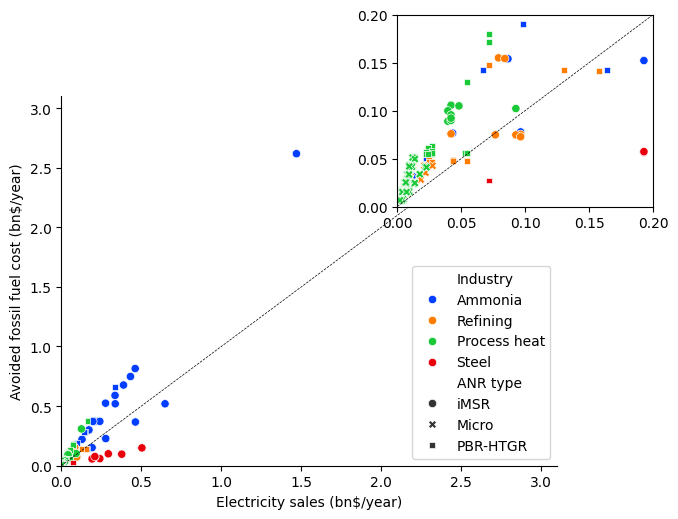

In [101]:
ammonia['Industry'] = 'Ammonia'
refining['Industry'] = 'Refining'
heat['Industry'] = 'Process heat'
steel['Industry'] = 'Steel'


total_elec = pd.concat([ammonia, refining, heat, steel], ignore_index=True)

ax = sns.scatterplot(data=total_elec, x='Elec sales (bn$/year)', y='Avoided fossil fuel cost (bn$/year)', palette='bright', hue='Industry', style='ANR type')
med_x = np.arange(0,4,0.05)
ax.plot(med_x, med_x, 'k--', linewidth=0.5)
ax.spines[['right', 'top']].set_visible(False)
ax.legend(loc='lower right')
ax.set_xlim(0,3.1)
ax.set_ylim(0,3.1)
ax.set_xlabel('Electricity sales (bn$/year)')
#plt.savefig('./results/steel_be_state_with_carbon_prices.png')

# this is an inset axes over the main axes
sub_ax = plt.axes([.65, .65, .4, .4]) 
sns.scatterplot(ax = sub_ax, data=total_elec, x='Elec sales (bn$/year)', y='Avoided fossil fuel cost (bn$/year)', palette='bright', style='ANR type', hue='Industry')
sub_ax.plot(med_x, med_x, 'k--', linewidth=0.5)
sub_ax.set_xlim(0, 0.2)
sub_ax.set_ylim(0, 0.2)
sub_ax.get_legend().set_visible(False)
sub_ax.set_xlabel('')
sub_ax.set_ylabel('')
plt.savefig('./results/avoided_fossil_vs_elec_sales.png')

# Viable decarbonization

In [102]:
gvt_incentives = [r'\$230/$t_{CO_2}$', r'\$270/$t_{CO_2}$', r'\$310/$t_{CO_2}$', r'\$3/$kg_{H_2}$', r'\$25/$MWh_e$']
viable_decarb_df = pd.DataFrame(columns=['CO2 2030', 'CO2 2040', 'CO2 2050', 'H2 PTC', 'Elec PTC'], index=['Ammonia', 'Refining', 'Process heat', 'Steel'])
viable_decarb_df

,CO2 2030,CO2 2040,CO2 2050,H2 PTC,Elec PTC
Ammonia,NaN,NaN,NaN,NaN,NaN
Refining,NaN,NaN,NaN,NaN,NaN
Process heat,NaN,NaN,NaN,NaN,NaN
Steel,NaN,NaN,NaN,NaN,NaN


In [103]:
# ammonia
ammonia = pd.read_csv('./results/ammonia_anr_lr_0_h2_lr_0_wacc_0.077_clean.csv')
ammonia = ammonia.merge(state_ng, left_on='state', right_on='abbrev')
ammonia.drop(columns=['state_x', 'state_y'], inplace=True)
ammonia.rename(columns={'abbrev':'state'}, inplace=True)


ammonia_c_2030 = ammonia[ammonia['Breakeven NG price ($/MMBtu)']<=nh3_carbon_prices[0]+ammonia['NG price ($/MMBtu)']]['Breakeven NG price ($/MMBtu)'].sum()
ammonia_c_2040 = ammonia[ammonia['Breakeven NG price ($/MMBtu)']<=nh3_carbon_prices[1]+ammonia['NG price ($/MMBtu)']]['Breakeven NG price ($/MMBtu)'].sum()
ammonia_c_2050 = ammonia[ammonia['Breakeven NG price ($/MMBtu)']<=nh3_carbon_prices[2]+ammonia['NG price ($/MMBtu)']]['Breakeven NG price ($/MMBtu)'].sum()
ammonia_h2_ptc = ammonia[ammonia['Breakeven NG price ($/MMBtu)']<=nh3_h2_ptc+ammonia['NG price ($/MMBtu)']]['Breakeven NG price ($/MMBtu)'].sum()
ammonia_elec_ptc = ammonia[ammonia['Breakeven NG price ($/MMBtu)']<=nh3_elec_ptc+ammonia['NG price ($/MMBtu)']]['Breakeven NG price ($/MMBtu)'].sum()
viable_decarb_df.loc['Ammonia', 'CO2 2030'] = ammonia_c_2030
viable_decarb_df.loc['Ammonia', 'CO2 2040'] = ammonia_c_2040
viable_decarb_df.loc['Ammonia', 'CO2 2050'] = ammonia_c_2050
viable_decarb_df.loc['Ammonia', 'H2 PTC'] = ammonia_h2_ptc
viable_decarb_df.loc['Ammonia', 'Elec PTC'] = ammonia_elec_ptc
viable_decarb_df

,CO2 2030,CO2 2040,CO2 2050,H2 PTC,Elec PTC
Ammonia,484.0,721.2,721.2,842.9,0.0
Refining,NaN,NaN,NaN,NaN,NaN
Process heat,NaN,NaN,NaN,NaN,NaN
Steel,NaN,NaN,NaN,NaN,NaN


In [104]:
# refining
refining = pd.read_csv('./results/refining_anr_lr_0_h2_lr_0_wacc_0.077_clean.csv')

refining = refining.merge(abbrev_states,left_on='state', right_on='state')
refining.drop(columns=['state'], inplace=True)
refining = refining.merge(state_ng, on='abbrev')


refining_c_2030 = refining[refining['Breakeven price ($/MMBtu)']<=refining_carbon_prices[0]+refining['NG price ($/MMBtu)']]['Breakeven price ($/MMBtu)'].sum()
refining_c_2040 = refining[refining['Breakeven price ($/MMBtu)']<=refining_carbon_prices[1]+refining['NG price ($/MMBtu)']]['Breakeven price ($/MMBtu)'].sum()
refining_c_2050 = refining[refining['Breakeven price ($/MMBtu)']<=refining_carbon_prices[2]+refining['NG price ($/MMBtu)']]['Breakeven price ($/MMBtu)'].sum()
refining_h2_ptc = refining[refining['Breakeven price ($/MMBtu)']<=refining_h2_ptc+refining['NG price ($/MMBtu)']]['Breakeven price ($/MMBtu)'].sum()
refining_elec_ptc = refining[refining['Breakeven price ($/MMBtu)']<=refining_elec_ptc+refining['NG price ($/MMBtu)']]['Breakeven price ($/MMBtu)'].sum()
viable_decarb_df.loc['Refining', 'CO2 2030'] = refining_c_2030
viable_decarb_df.loc['Refining', 'CO2 2040'] = refining_c_2040
viable_decarb_df.loc['Refining', 'CO2 2050'] = refining_c_2050
viable_decarb_df.loc['Refining', 'H2 PTC'] = refining_h2_ptc
viable_decarb_df.loc['Refining', 'Elec PTC'] = refining_elec_ptc
viable_decarb_df

,CO2 2030,CO2 2040,CO2 2050,H2 PTC,Elec PTC
Ammonia,484.0,721.2,721.2,842.9,0.0
Refining,623.9,654.1,654.1,623.9,188.3
Process heat,NaN,NaN,NaN,NaN,NaN
Steel,NaN,NaN,NaN,NaN,NaN


In [105]:
# process heat
heat = pd.read_csv('./results/process_heat_anr_lr_0_h2_lr_0_wacc_0.077_clean.csv')
heat = heat.merge(state_ng, left_on='state', right_on='abbrev')
heat.drop(columns=['state_x', 'state_y'], inplace=True)
heat.rename(columns={'abbrev':'state'}, inplace=True)

heat_c_2030 = heat[heat['Breakeven NG price ($/MMBtu)']<=heat_carbon_prices[0]+heat['NG price ($/MMBtu)']]['Breakeven NG price ($/MMBtu)'].sum()
heat_c_2040 = heat[heat['Breakeven NG price ($/MMBtu)']<=heat_carbon_prices[1]+heat['NG price ($/MMBtu)']]['Breakeven NG price ($/MMBtu)'].sum()
heat_c_2050 = heat[heat['Breakeven NG price ($/MMBtu)']<=heat_carbon_prices[2]+heat['NG price ($/MMBtu)']]['Breakeven NG price ($/MMBtu)'].sum()
heat_h2_ptc = heat[heat['Breakeven NG price ($/MMBtu)']<=heat_h2_ptc+heat['NG price ($/MMBtu)']]['Breakeven NG price ($/MMBtu)'].sum()
heat_elec_ptc = heat[heat['Breakeven NG price ($/MMBtu)']<=heat_elec_ptc+heat['NG price ($/MMBtu)']]['Breakeven NG price ($/MMBtu)'].sum()
viable_decarb_df.loc['Process heat', 'CO2 2030'] = heat_c_2030
viable_decarb_df.loc['Process heat', 'CO2 2040'] = heat_c_2040
viable_decarb_df.loc['Process heat', 'CO2 2050'] = heat_c_2050
viable_decarb_df.loc['Process heat', 'H2 PTC'] = heat_h2_ptc
viable_decarb_df.loc['Process heat', 'Elec PTC'] = heat_elec_ptc
viable_decarb_df



,CO2 2030,CO2 2040,CO2 2050,H2 PTC,Elec PTC
Ammonia,484.0,721.2,721.2,842.9,0.0
Refining,623.9,654.1,654.1,623.9,188.3
Process heat,0.0,0.0,0.0,4379.6,14.1
Steel,NaN,NaN,NaN,NaN,NaN


In [106]:
# steel
steel = pd.read_csv('./results/steel_anr_lr_0_h2_lr_0_wacc_0.077_clean.csv')
division_coal = pd.read_excel('./input_data/coal_prices_2023_division_us.xlsx', sheet_name='coal_prices')
state_to_division_map = pd.read_excel('./input_data/coal_prices_2023_division_us.xlsx', sheet_name='state_to_division_map')
state_coal = state_to_division_map.merge(division_coal, on='division')
steel = steel.merge(state_coal, on='state')

steel


,Plant,state,Steel production capacity (ttpa),Demand (MT H2/day),HTSE,ANR,#,Net Rev. (M$/year),Ann. avoided CO2 emissions (MMT-CO2/year),Breakeven coal price ($/ton),Viable avoided emissions (MMT-CO2/year),Avoided cost of CO2 ($/ton),division,price 2023 ($/tcoal)
0,U.S. Steel Gary Works,IN,6622,1307.3,1308,iMSR,12,-2200.7,9.9,47.7,17.819341,222.3,East North Central,226.070000
1,Cleveland-Cliffs Indiana Harbor steel plant,IN,5236,1033.7,1034,iMSR,9,-1710.2,5.1,39.1,5.128152,335.3,East North Central,226.070000
2,Cleveland-Cliffs Burns Harbor steel plant,IN,3635,717.6,718,iMSR,7,-1233.2,6.6,58.1,30.501912,186.8,East North Central,226.070000
3,Cleveland-Cliffs Cleveland steel plant,OH,2810,554.8,555,iMSR,5,-928.2,2.8,44.6,7.906169,331.5,East North Central,226.070000
4,Cleveland-Cliffs Middletown steel plant,OH,2090,412.6,413,iMSR,4,-707.6,3.1,57.0,20.924361,228.3,East North Central,226.070000
5,U.S. Steel Granite City Works,IL,2540,501.5,502,iMSR,5,-868.4,1.8,62.1,32.286177,482.4,East North Central,226.070000
6,Cleveland-Cliffs Riverdale steel plant,IL,1000,197.4,198,PBR-HTGR,3,-338.7,0.1,57.3,21.001446,3387.0,East North Central,226.070000
7,Cleveland-Cliffs Dearborn steel plant,MI,2500,493.6,494,iMSR,5,-859.5,0.9,65.0,33.155422,955.0,East North Central,226.070000
8,U.S. Steel Edgar Thomson Plant,PA,2078,410.2,411,iMSR,4,-704.9,2.9,58.1,23.875414,243.1,Middle Atlantic,205.403333


In [107]:
steel_c_2030 = steel[steel['Breakeven coal price ($/ton)']<=steel_carbon_prices[0]+steel['price 2023 ($/tcoal)']]['Breakeven coal price ($/ton)'].sum()
steel_c_2040 = steel[steel['Breakeven coal price ($/ton)']<=steel_carbon_prices[1]+steel['price 2023 ($/tcoal)']]['Breakeven coal price ($/ton)'].sum()
steel_c_2050 = steel[steel['Breakeven coal price ($/ton)']<=steel_carbon_prices[2]+steel['price 2023 ($/tcoal)']]['Breakeven coal price ($/ton)'].sum()
steel_h2_ptc = steel[steel['Breakeven coal price ($/ton)']<=steel_h2_ptc+steel['price 2023 ($/tcoal)']]['Breakeven coal price ($/ton)'].sum()
steel_elec_ptc = steel[steel['Breakeven coal price ($/ton)']<=steel_elec_ptc+steel['price 2023 ($/tcoal)']]['Breakeven coal price ($/ton)'].sum()
viable_decarb_df.loc['Steel', 'CO2 2030'] = steel_c_2030
viable_decarb_df.loc['Steel', 'CO2 2040'] = steel_c_2040
viable_decarb_df.loc['Steel', 'CO2 2050'] = steel_c_2050
viable_decarb_df.loc['Steel', 'H2 PTC'] = steel_h2_ptc
viable_decarb_df.loc['Steel', 'Elec PTC'] = steel_elec_ptc
viable_decarb_df = viable_decarb_df.transpose()



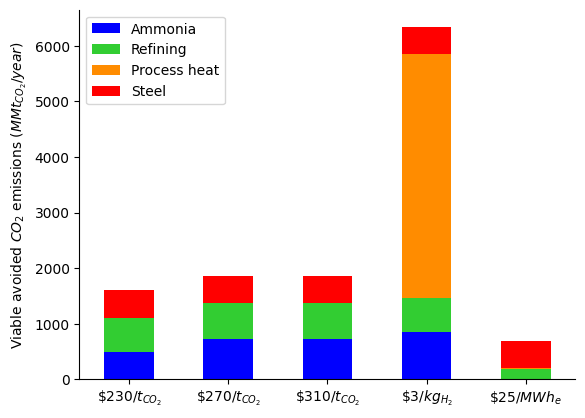

In [108]:
colors = ['blue', 'limegreen', 'darkorange',  'red'] ## Colors for the bars
viable_decarb_df.plot(kind='bar', stacked=True, color=colors) ## Plot
plt.ticklabel_format(style='plain', useOffset=False, axis='y') ## No offset
plt.gca().set_ylabel(r"Viable avoided $CO_2$ emissions ($MMt_{CO_2}/year$)") ## Set Y-axis
plt.gca().set_xticks(np.arange(viable_decarb_df.shape[0]), labels = gvt_incentives, rotation=0 )
plt.gca().spines[['right', 'top']].set_visible(False)
plt.gca().legend(loc='upper left')
plt.savefig('./results/viable_avoided_emissions_incentives.png')